# Binning with uniform kernel

In [2]:
import numpy as np
import napari
import matplotlib.pyplot as plt
from skimage.io import imread # to load images from files
from scipy.ndimage import correlate, convolve

### Creating a test image array

In [3]:
image_array = np.arange(120).reshape(5, 4, 6) # (signal_decay A * np.exp(-(1 / tau) * x), x-axis, y-axis)
print("Original Array:")
print(image_array)

Original Array:
[[[  0   1   2   3   4   5]
  [  6   7   8   9  10  11]
  [ 12  13  14  15  16  17]
  [ 18  19  20  21  22  23]]

 [[ 24  25  26  27  28  29]
  [ 30  31  32  33  34  35]
  [ 36  37  38  39  40  41]
  [ 42  43  44  45  46  47]]

 [[ 48  49  50  51  52  53]
  [ 54  55  56  57  58  59]
  [ 60  61  62  63  64  65]
  [ 66  67  68  69  70  71]]

 [[ 72  73  74  75  76  77]
  [ 78  79  80  81  82  83]
  [ 84  85  86  87  88  89]
  [ 90  91  92  93  94  95]]

 [[ 96  97  98  99 100 101]
  [102 103 104 105 106 107]
  [108 109 110 111 112 113]
  [114 115 116 117 118 119]]]


### Kernel definition

In [4]:
bin_size = 2

kernel=np.full((bin_size,bin_size),1)
print(kernel)

[[1 1]
 [1 1]]


In [5]:
image_binned = np.zeros_like(image_array)

for i in range(image_array.shape[0]):
    image_binned[i, :, :] = convolve(image_array[i, :, :],kernel)

image_binned

array([[[ 14,  18,  22,  26,  30,  32],
        [ 38,  42,  46,  50,  54,  56],
        [ 62,  66,  70,  74,  78,  80],
        [ 74,  78,  82,  86,  90,  92]],

       [[110, 114, 118, 122, 126, 128],
        [134, 138, 142, 146, 150, 152],
        [158, 162, 166, 170, 174, 176],
        [170, 174, 178, 182, 186, 188]],

       [[206, 210, 214, 218, 222, 224],
        [230, 234, 238, 242, 246, 248],
        [254, 258, 262, 266, 270, 272],
        [266, 270, 274, 278, 282, 284]],

       [[302, 306, 310, 314, 318, 320],
        [326, 330, 334, 338, 342, 344],
        [350, 354, 358, 362, 366, 368],
        [362, 366, 370, 374, 378, 380]],

       [[398, 402, 406, 410, 414, 416],
        [422, 426, 430, 434, 438, 440],
        [446, 450, 454, 458, 462, 464],
        [458, 462, 466, 470, 474, 476]]])

In [6]:
viewer = napari.Viewer()
original_layer = viewer.add_image(image_array)
binned_layer = viewer.add_image(image_binned)

In [7]:
from readPTU_FLIM import PTUreader
data_path = "/Users/lana/Documents/PoLHiWi2023/Test_data/2a_FLIM_single_image.ptu"
ptu_file = PTUreader(data_path, print_header_data = False)
flim_data_stack, intensity_image = ptu_file.get_flim_data_stack()

flim_data_stack_for_napari = np.moveaxis(flim_data_stack, [0, 1], [-2, -1])

flim_data_stack_for_napari = flim_data_stack_for_napari[0, :, :, :]

TCSPC Hardware: PicoHarpT3
Raw Data has been Read!



In [8]:
laser_frequency = ptu_file.head['TTResult_SyncRate'] *1E-6 #MHz

In [9]:
from FLIM_phasor import *
time_array = create_time_array(laser_frequency, n_points = flim_data_stack_for_napari.shape[0])

In [10]:
flim_data_stack_for_napari.shape


#data_layer = viewer.add_image(flim_data_stack_for_napari)

(271, 512, 512)

In [19]:
viewer = napari.Viewer()
viewer.add_image(flim_data_stack_for_napari)

<Image layer 'flim_data_stack_for_napari' at 0x7fb34eecb910>

In [20]:
bin_size = 3

kernel=np.full((bin_size,bin_size),1)
print(kernel)

[[1 1 1]
 [1 1 1]
 [1 1 1]]


In [21]:
image_binned = np.zeros_like(flim_data_stack_for_napari)

for i in range(flim_data_stack_for_napari.shape[0]):
    image_binned[i, :, :] = convolve(flim_data_stack_for_napari[i, :, :],kernel)

In [22]:
viewer.add_image(image_binned)

<Image layer 'image_binned' at 0x7fb365462cd0>

In [23]:
threshold = 43

space_mask = intensity_image > threshold
threshold

43

In [26]:
time_array = create_time_array(laser_frequency, n_points = flim_data_stack_for_napari.shape[0])
time_step = time_array[1] # ns

heights, bin_edges = np.histogram(np.ravel(np.argmax(flim_data_stack_for_napari, axis=0) * time_step), bins=time_array)
start_index = np.argmax(heights[1:]) + 1
time_mask = time_array >= time_array[start_index]

In [28]:
number_of_harmonics = 2

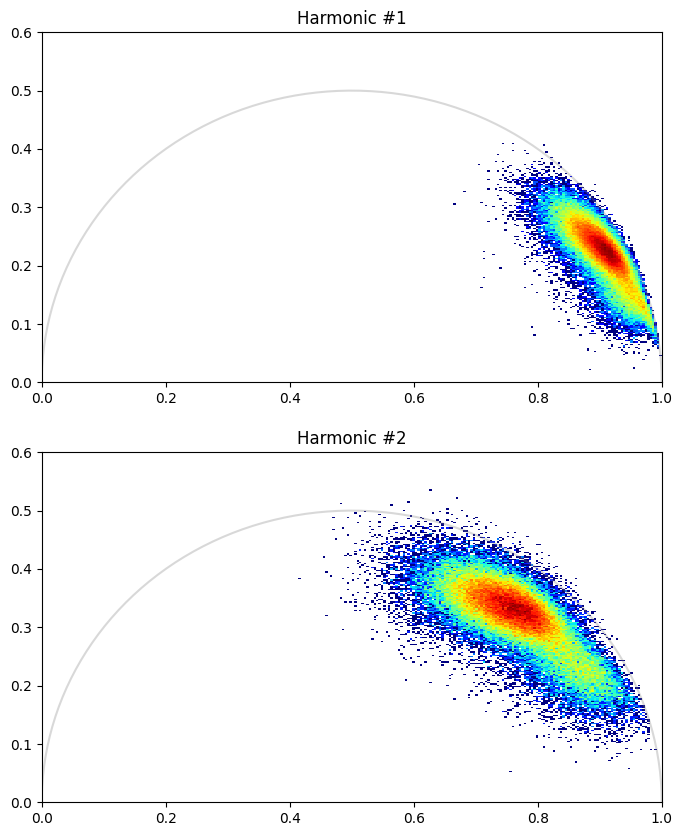

In [30]:
flim_image = flim_data_stack_for_napari
fig, ax = plt.subplots(number_of_harmonics, 1, figsize=(8, number_of_harmonics*5))
for i in range(number_of_harmonics):
    g, s, dc = get_phasor_components(flim_image[time_mask], harmonic = i+1)

    # Apply threshold
    x = np.ravel(g[space_mask])
    y = np.ravel(s[space_mask])
    
    if number_of_harmonics == 1:
        current_axis = ax
    else:
        current_axis = ax[i]
    
    add_phasor_circle(current_axis)
    #add_tau_lines(current_axis, tau_list, laser_frequency) 
    # current_axis.scatter(x,y, s=5, alpha=0.1, c='k')
    output = current_axis.hist2d(x, y, bins=256, norm='log', range=[[0, 1], [0, 0.6]], cmap = 'jet')
    title = 'Harmonic #' + str(i+1)
    current_axis.set_title(title)

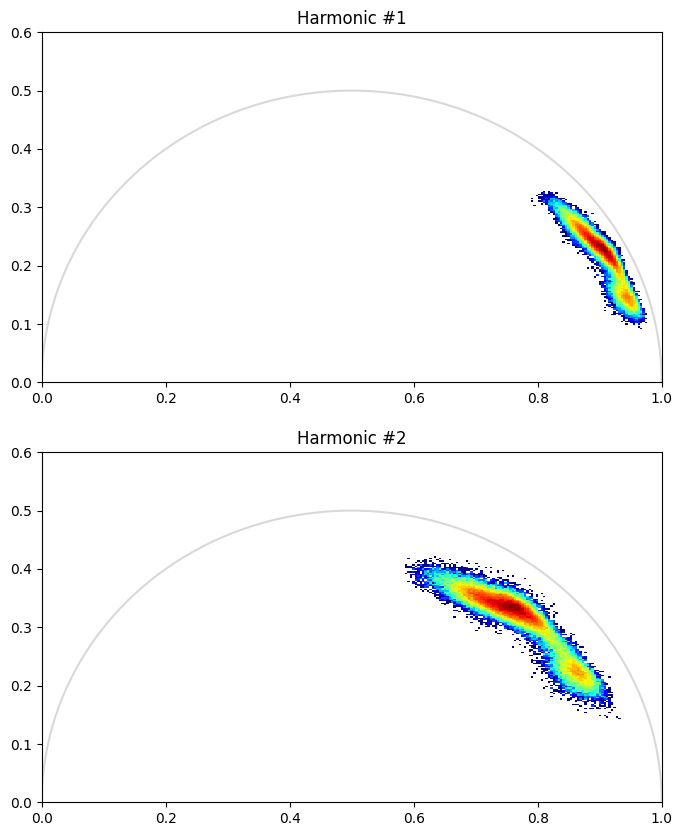

/Users/lana/Documents/GitHub/napari-flim-phasor-calculator/src/napari_flim_phasor_calculator/_widget.py:118: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  value in napari_viewer.window._dock_widgets.items()]
/Users/lana/Documents/GitHub/napari-flim-phasor-calculator/src/napari_flim_phasor_calculator/_widget.py:146: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  widgets = napari_viewer.window._dock_widgets[


In [31]:
flim_image = image_binned
fig, ax = plt.subplots(number_of_harmonics, 1, figsize=(8, number_of_harmonics*5))
for i in range(number_of_harmonics):
    g, s, dc = get_phasor_components(flim_image[time_mask], harmonic = i+1)

    # Apply threshold
    x = np.ravel(g[space_mask])
    y = np.ravel(s[space_mask])
    
    if number_of_harmonics == 1:
        current_axis = ax
    else:
        current_axis = ax[i]
    
    add_phasor_circle(current_axis)
    #add_tau_lines(current_axis, tau_list, laser_frequency) 
    # current_axis.scatter(x,y, s=5, alpha=0.1, c='k')
    output = current_axis.hist2d(x, y, bins=256, norm='log', range=[[0, 1], [0, 0.6]], cmap = 'jet')
    title = 'Harmonic #' + str(i+1)
    current_axis.set_title(title)